## Importing Packages

In [ ]:
# importing some useful packages
import matplotlib.pyplot as plt
import numpy as np
import cv2
import glob
from moviepy.editor import VideoFileClip

# showing images in notebook
%matplotlib inline

Imageio: 'ffmpeg-linux64-v3.3.1' was not found on your computer; downloading it now.
Try 1. Download from https://github.com/imageio/imageio-binaries/raw/master/ffmpeg/ffmpeg-linux64-v3.3.1 (43.8 MB)
Downloading: 8192/45929032 bytes (0.0%)2121728/45929032 bytes (4.6%)5152768/45929032 bytes (11.2%)8355840/45929032 bytes (18.2%)11599872/45929032 bytes (25.3%)14786560/45929032 bytes (32.2%)17948672/45929032 bytes (39.1%)21110784/45929032 bytes (46.0%)24387584/45929032 bytes (53.1%)26681344/45929032 bytes (58.1%)28917760/45929032 bytes (63.0%)30851072/45929032 bytes (67.2%)34062336/45929032 bytes (74.2%)

## Visualization part

In [ ]:
def show_image(image, title='Image', cmap_type='gray'):
    plt.imshow(image, cmap = cmap_type)
    plt.title(title)

## Read In An Image

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
This image is of shape (720, 1280, 3)


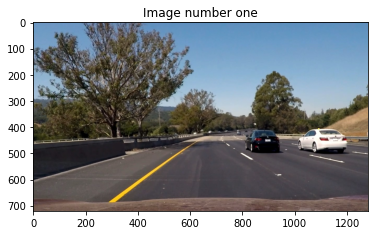

In [28]:
# Reading an image
from google.colab import drive
drive.mount('/content/drive')

images_paths = glob.glob("/content/drive/MyDrive/Project_data/test_images/*.jpg")
images = [plt.imread(image) for image in images_paths]

# getting img dimensions and printing it
image_idx = 0

print("This image is of shape {}".format(images[image_idx].shape))
show_image(images[image_idx], "Image number one")

In [ ]:
### Apply gaussian blue to eliminate noise
def gaussian_blur(img, kernel_size):
    return cv2.GaussianBlur(img, (kernel_size, kernel_size), 0)

In [ ]:
### This function returns the prespective and inverse prespective matrix for a prespective transform
def perspectiveTransform(srcPoints, dstPoints):
    M = cv2.getPerspectiveTransform(srcPoints, dstPoints)
    Minv = cv2.getPerspectiveTransform(dstPoints, srcPoints)
    return M, Minv
    
### This function applies prespective transform to an image and returns the warped image
def warpPerspective(img, imgSize, M):
    return cv2.warpPerspective(img, M, imgSize, cv2.INTER_LINEAR)

## Start your pipeline Here

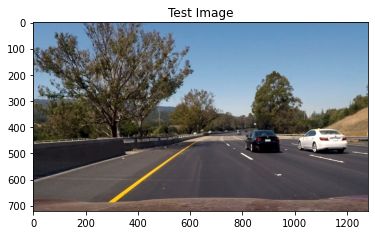

In [ ]:
test_image = images[0]

show_image(test_image, "Test Image")

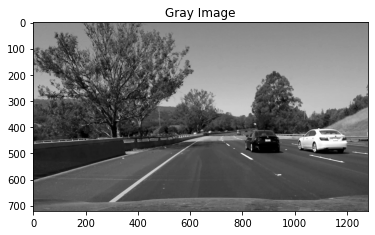

In [ ]:
gray = cv2.cvtColor(test_image, cv2.COLOR_RGB2GRAY)

show_image(gray, "Gray Image")

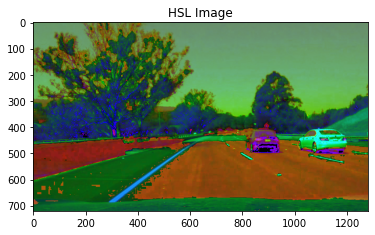

In [ ]:
hls_image = cv2.cvtColor(test_image, cv2.COLOR_RGB2HLS)

show_image(hls_image, "HSL Image")

In [ ]:
h_channel = hls_image[:, :, 0]
l_channel = hls_image[:, :, 1]
s_channel = hls_image[:, :, 2]

In [ ]:
np.max(h_channel), np.max(l_channel), np.max(s_channel)

(180, 255, 255)

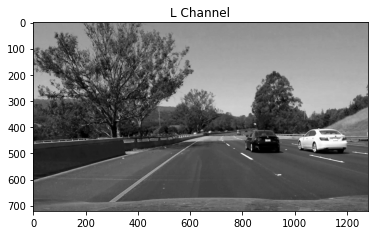

In [ ]:
show_image(l_channel, "L Channel")

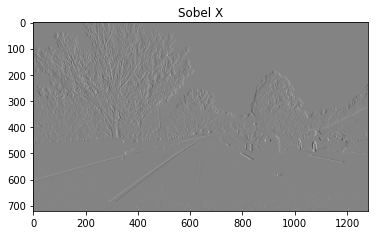

In [ ]:
sobelx = cv2.Sobel(l_channel, cv2.CV_64F, 1, 0)

show_image(sobelx, "Sobel X")

In [ ]:
np.max(sobelx), np.min(sobelx)

(803.0, -853.0)

In [ ]:
abs_sobel_x = np.absolute(sobelx)
scaled_sobel = 255 * ((abs_sobel_x) / np.max(abs_sobel_x))

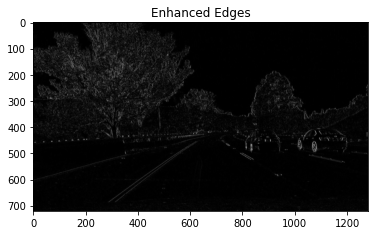

In [ ]:
show_image(scaled_sobel, "Enhanced Edges")

In [ ]:
sx_thresh = [10, 100]

sx_binary = np.zeros_like(scaled_sobel)
sx_binary[(scaled_sobel > sx_thresh[0]) & (scaled_sobel < sx_thresh[1])] = 1

1280


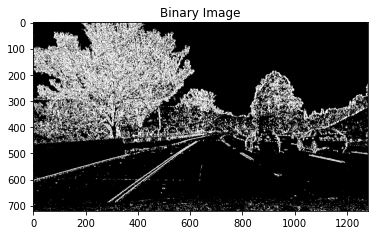

In [ ]:
show_image(sx_binary, "Binary Image")
print(sx_binary.shape[1])

In [ ]:
corners = np.float32([[190,720],[589,457],[698,457],[1145,720]])
new_top_left=np.array([corners[0,0],0])
new_top_right=np.array([corners[3,0],0])
offset=[150,0]
    
img_size = (sx_binary.shape[1], sx_binary.shape[0])
srcPoints = np.float32([corners[0],corners[1],corners[2],corners[3]])
dstPoints = np.float32([corners[0]+offset,new_top_left+offset,new_top_right-offset ,corners[3]-offset]) 

M, Minv = perspectiveTransform(srcPoints, dstPoints)

warped_image = warpPerspective(sx_binary, sx_binary.astype(np.float32).shape[1::-1], M)
print(img_size[0])

1280


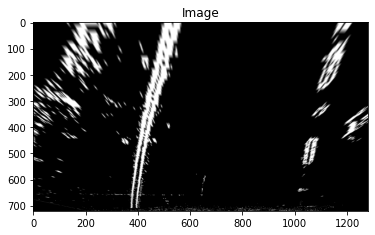

In [ ]:
show_image(warped_image)

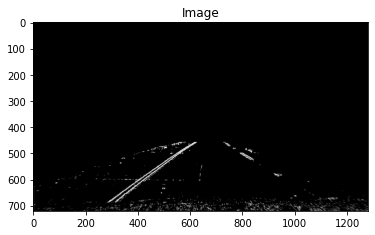

In [ ]:
origianl_image = warpPerspective(warped_image, sx_binary.shape[1::-1], Minv)
show_image(origianl_image)

In [ ]:
# Whole Pipeline
def DetectLane(img):
    
    #Color tranformations
    hls_image = cv2.cvtColor(img, cv2.COLOR_RGB2HLS)
    h_channel = hls_image[:, :, 0]
    l_channel = hls_image[:, :, 1]
    s_channel = hls_image[:, :, 2]
    sobelx = cv2.Sobel(l_channel, cv2.CV_64F, 1, 0)
    abs_sobel_x = np.absolute(sobelx)
    scaled_sobel = 255 * ((abs_sobel_x) / np.max(abs_sobel_x))
    sx_thresh = [10, 100]
    sx_binary = np.zeros_like(scaled_sobel)
    sx_binary[(scaled_sobel > sx_thresh[0]) & (scaled_sobel < sx_thresh[1])] = 1
    
    
    #perform the warp perspective transform
    
    img_size = (img.shape[1],img.shape[0])
    
    corners = np.float32([[190,720],[589,457],[698,457],[1145,720]])
    new_top_left=np.array([corners[0,0],0])
    new_top_right=np.array([corners[3,0],0])
    offset=[150,0]
    srcPoints = np.float32([corners[0],corners[1],corners[2],corners[3]])
    dstPoints = np.float32([corners[0]+offset,new_top_left+offset,new_top_right-offset ,corners[3]-offset]) 

    M, Minv = perspectiveTransform(srcPoints, dstPoints)

    warped = warpPerspective(sx_binary, sx_binary.astype(np.float32).shape[1::-1], M)  
    

    #set up the overall class to do the lane line tracking
    window_width = 25
    window_height = 80
    margin = 25

    
    window_centroids = find_centroids(warped)
    
    # points used to find the right & left lanes
    rightx = []
    leftx = []

    for level in range(0,len(window_centroids)):
        # Add center value found in frame to the list of lane points per left, right
        leftx.append(window_centroids[level][0])
        rightx.append(window_centroids[level][1])

    #fit the lane boundaries to the left, right center positions found
    yvals = range(0,warped.shape[0])
    
    res_yvals = np.arange(warped.shape[0]-(window_height/2),0,-window_height)
    
    left_fit = np.polyfit(res_yvals, leftx, 2)
    left_fitx = left_fit[0]*yvals*yvals + left_fit[1]*yvals + left_fit[2]
    left_fitx = np.array(left_fitx,np.int32)
    
    right_fit = np.polyfit(res_yvals, rightx, 2)
    right_fitx = right_fit[0]*yvals*yvals + right_fit[1]*yvals + right_fit[2]
    right_fitx = np.array(right_fitx,np.int32)
    
    left_lane = np.array(list(zip(np.concatenate((left_fitx-window_width/2, left_fitx[::-1]+window_width/2),axis=0),np.concatenate((yvals,yvals[::-1]),axis=0))),np.int32)
    right_lane = np.array(list(zip(np.concatenate((right_fitx-window_width/2, right_fitx[::-1]+window_width/2),axis=0),np.concatenate((yvals,yvals[::-1]),axis=0))),np.int32)
    middle_marker = np.array(list(zip(np.concatenate((right_fitx-window_width/2, right_fitx[::-1]+window_width/2),axis=0),np.concatenate((yvals,yvals[::-1]),axis=0))),np.int32)
    inner_lane = np.array(list(zip(np.concatenate((left_fitx+window_width/2, right_fitx[::-1]-window_width/2),axis=0),np.concatenate((yvals,yvals[::-1]),axis=0))),np.int32)

    road = np.zeros_like(img)
    road_bkg = np.zeros_like(img)
    cv2.fillPoly(road,[left_lane],color=[255,0,0])
    cv2.fillPoly(road,[right_lane],color=[0,0,255])
    cv2.fillPoly(road,[inner_lane],color=[0,255,0])
    
    road_warped = cv2.warpPerspective(road,Minv,img_size,flags=cv2.INTER_LINEAR)
    
    base = cv2.addWeighted(img,1.0,road_warped, -1.0, 0.0)
    result = cv2.addWeighted(base,1.0,road_warped, 1.0, 0.0)
    ym_per_pix = 0.01 # meters per pixel in y dimension
    xm_per_pix = 0.01 # meters per pixel in x dimension

    curve_fit_cr = np.polyfit(np.array(res_yvals,np.float32)*ym_per_pix,np.array(leftx,np.float32)*xm_per_pix,2)
    curverad = ((1 + (2*curve_fit_cr[0]*yvals[-1]*ym_per_pix + curve_fit_cr[1])**2)**1.5) /np.absolute(2*curve_fit_cr[0])
    
    # Calculate the offset of the car on the road
    camera_center = (left_fitx[-1] + right_fitx[-1])/2
    center_diff = (camera_center-warped.shape[1]/2)*xm_per_pix
    side_pos = 'left'
    if center_diff <= 0:
        side_pos = 'right'

    # draw the text showing curvature, offset & speed
    cv2.putText(result, 'Radius of Curvature='+str(round(curverad,3))+'m ',(50,50),cv2.FONT_HERSHEY_SIMPLEX,1,(255,255,255),2)
    cv2.putText(result, 'Vehicle is '+str(abs(round(center_diff,3)))+'m '+side_pos+' of center',(50,100), cv2.FONT_HERSHEY_SIMPLEX,1,(255,255,255),2)

    return result

Output_video = 'output2_tracked.mp4'
Input_video = '/content/drive/MyDrive/Project_data/project_video.mp4'

clip1 = VideoFileClip(Input_video)
video_clip = clip1.fl_image(DetectLane) # This function expects color images
video_clip.write_videofile(Output_video, audio=False)

[MoviePy] >>>> Building video output2_tracked.mp4
[MoviePy] Writing video output2_tracked.mp4


 16%|█▋        | 208/1261 [00:27<02:19,  7.54it/s]


KeyboardInterrupt: ignored

In [ ]:
def find_centroids(warped):
    
    recent_centers=[]
    window_width = 25
    window_height = 80
    margin = 25

    window_centroids = [] # store the (left,right) window centroid positions per level
    window = np.ones(window_width) # create our window template that we will use for convolutions

    # first find the two starting positions for the left & right lane by using np.sum to get the vertical image slice
    # and then np.convolve the vertical image slice with the window template

    #sum quarter bottom of image to get slice, could use a different ratio
    l_sum = np.sum(warped[int(3*warped.shape[0]/4):,:int(warped.shape[1]/2)], axis=0)
    l_center = np.argmax(np.convolve(window,l_sum))-window_width/2
    r_sum = np.sum(warped[int(3*warped.shape[0]/4):,int(warped.shape[1]/2):], axis=0)
    r_center = np.argmax(np.convolve(window,r_sum))-window_width/2+int(warped.shape[1]/2)

    # Add what we found for the 1st layer
    window_centroids.append((l_center,r_center))

    # Go thru each layer looking for max pixel locations
    for level in range(1,(int)(warped.shape[0]/window_height)):
    # convolve the window into the vertical slice of the image
        image_layer = np.sum(warped[int(warped.shape[0]-(level+1)*window_height):int(warped.shape[0]-level*window_height),:], axis=0)
        conv_signal = np.convolve(window, image_layer)
        # Find the best left centroid by using past left center as a reference
        # Use window_width/2 as offset because convolution signal reference is at right side of window, not center of window
        offset = window_width/2
        l_min_index = int(max(l_center+offset-margin,0))
        l_max_index = int(min(l_center+offset+margin,warped.shape[1]))
        l_center = np.argmax(conv_signal[l_min_index:l_max_index])+l_min_index-offset
        # Find the best right centroid by using past right center as a reference
        r_min_index = int(max(r_center+offset-margin,0))
        r_max_index = int(min(r_center+offset+margin,warped.shape[1]))
        r_center = np.argmax(conv_signal[r_min_index:r_max_index])+r_min_index-offset
        # Add what we found for that layer
        window_centroids.append((l_center,r_center))

    recent_centers.append(window_centroids)
    # return averaged values of the line centers, helps to keep the markers from sliding too much
    return np.average(recent_centers[-15:], axis=0)
